In [1]:
%reset -f

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')           ## CPU is faster here !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks',
        font='sans-serif', font_scale=1, color_codes=True, rc={"lines.linewidth": 2})

from updec.utils import polyharmonic, multiquadric
from updec.operators import *
from updec.utils import print_line_by_line

In [3]:
x = jnp.zeros((10, 3))
x[9:10]

DeviceArray([[0., 0., 0.]], dtype=float32)

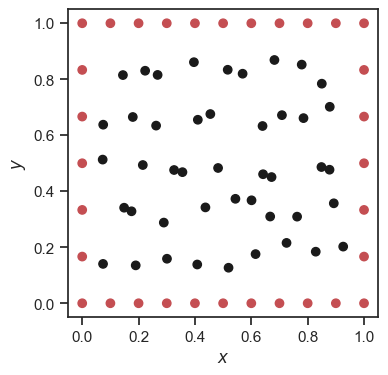

In [4]:
RBF = polyharmonic      ## Can define which rbf to use
MAX_DEGREE = 2

facet_types={0:"d", 1:"d", 2:"d", 3:"d"}
cloud = Cloud(Nx=11, Ny=7, facet_types=facet_types, noise_seed=34)
cloud.visualize_cloud(figsize=(4,4));

In [5]:
print("\n=== Meshfree cloud for RBF method ===\n")
print()
print("Cloud bounding box: Nx =", cloud.Nx, " -  Ny =", cloud.Ny)
print()
print("Boundary types (0=internal, 1=dirichlet, 2=neumann):\n", cloud.node_boundary_types)
print("Number of: \n\t-Internal points: Ni =", cloud.Ni, "\n\t-Dirichlet points: Md =", cloud.Nd, "\n\t-Neumann points: Mn =", cloud.Nn)
print("Surface types:\n", cloud.facet_types)
print()
print("Global indices:\n", cloud.global_indices)
print()
# # print("Global indices reversed:\n", cloud.global_indices_rev)
# # print()
# print("Outward normals on Neumann boundaries:")
# print_line_by_line(cloud.outward_normals)
# print()
# print("Node coordinates:", )
# print_line_by_line(cloud.nodes)
# print()
print("Local supports (n closest neighbours):")
print_line_by_line(cloud.local_supports)


=== Meshfree cloud for RBF method ===


Cloud bounding box: Nx = 11  -  Ny = 7

Boundary types (0=internal, 1=dirichlet, 2=neumann):
 {45: 'd', 46: 'd', 47: 'd', 48: 'd', 49: 'd', 50: 'd', 51: 'd', 52: 'd', 0: 'i', 1: 'i', 2: 'i', 3: 'i', 4: 'i', 53: 'd', 54: 'd', 5: 'i', 6: 'i', 7: 'i', 8: 'i', 9: 'i', 55: 'd', 56: 'd', 10: 'i', 11: 'i', 12: 'i', 13: 'i', 14: 'i', 57: 'd', 58: 'd', 15: 'i', 16: 'i', 17: 'i', 18: 'i', 19: 'i', 59: 'd', 60: 'd', 20: 'i', 21: 'i', 22: 'i', 23: 'i', 24: 'i', 61: 'd', 62: 'd', 25: 'i', 26: 'i', 27: 'i', 28: 'i', 29: 'i', 63: 'd', 64: 'd', 30: 'i', 31: 'i', 32: 'i', 33: 'i', 34: 'i', 65: 'd', 66: 'd', 35: 'i', 36: 'i', 37: 'i', 38: 'i', 39: 'i', 67: 'd', 68: 'd', 40: 'i', 41: 'i', 42: 'i', 43: 'i', 44: 'i', 69: 'd', 70: 'd', 71: 'd', 72: 'd', 73: 'd', 74: 'd', 75: 'd', 76: 'd'}
Number of: 
	-Internal points: Ni = 45 
	-Dirichlet points: Md = 32 
	-Neumann points: Mn = 0
Surface types:
 {0: 'd', 1: 'd', 2: 'd', 3: 'd'}

Global indices:
 [[45 46 47 48 49 50 

In [ ]:
## Operates on radial basis functions and polynomials at position x: don't forget the None. It is important!
# @jax.jit
# @partial(jax.jit, static_argnums=2)
def my_diff_operator(x, node=None, monomial=None):
    return  -1 * nodal_laplacian(x, node, monomial, rbf=RBF)

known_field = jnp.ones((cloud.N, 2))
## Operates on entire fields at position x (inside node)
# @jax.jit
def my_rhs_operator(x):
    # return divergence(x, known_field, cloud, rbf=RBF, max_degree=2)
    return 2.0

d_func = lambda node: 1.0
n_func = lambda node: 1.0
boundary_conditions = {0:d_func, 1:d_func, 2:d_func, 3:n_func}

In [6]:
unknown_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)
# unknown_field

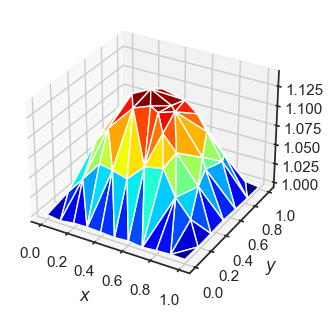

In [7]:
cloud.visualize_field(unknown_field, cmap="jet", projection="3d", ax=None, figsize=(8,8));

## Code profiling

In [8]:
# ### Profiling the code
# import cProfile
# cloud = Cloud(Nx=11, Ny=7, facet_types=facet_types, noise_seed=34)
# cProfile.run('pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)', filename=None, sort=2)